# Reproducing the simulations from Angelopoulos et al. (2021)

In this tutorial, we use :class:`mapie.regression.MapieClassifier` to reproduce the results of Experiment 1 from Angelopoulos et al. (2021). In this Experiment, the so-called "Naive", "Top-K", and Adaptive Prediction Set methods are used to estimate the the coverage levels and mean prediction set sizes obtained with various deep learning models on the Image Net dataset.

The pre-trained neural networks are downloaded from `torchvision` and are made compatible with the `scikit-learn` API thanks to a custom class. The images are downloaded from ...

Before starting the tutorial, we need to install the `torch`, `torchvision`, and `opencv` packages which are not available in the default MAPIE environment.

In [2]:
import glob
import os
import random
import re
import requests
from typing import Dict, List, Tuple, Union
import zipfile
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision.models as models
from mapie.metrics import classification_coverage_score
from mapie.classification import MapieClassifier
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torchvision import datasets, transforms

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 1. Loading the data

In [6]:
!kaggle datasets download -d ifigotin/imagenetmini-1000 --force
!kaggle competitions download -c imagenet-object-localization-challenge -f LOC_synset_mapping.txt --force

100%|█████████████████████████████████████▉| 3.92G/3.92G [02:13<00:00, 27.9MB/s]
100%|██████████████████████████████████████| 3.92G/3.92G [02:13<00:00, 31.6MB/s]
  0%|                                               | 0.00/30.9k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 30.9k/30.9k [00:00<00:00, 5.14MB/s]


In [7]:
ZIP_NAME = 'imagenetmini-1000.zip'
PATH_IMG_UNZIP  = 'imagenet_images'
PATH_LABELS = 'https://gist.githubusercontent.com/ShamsUlAzeem/3ea5740b960d854f4bd43e7322b858e3/raw/e8e3d428fb94af3c1c20beea9183de364ecbc3a5/imagenet-labels.json'
LABELS = "LOC_synset_mapping.txt"
PATH_VAL = os.path.join(PATH_IMG_UNZIP, 'imagenet-mini/val')

In [8]:
with zipfile.ZipFile(ZIP_NAME, 'r') as zip_ref:
    zip_ref.extractall(PATH_IMG_UNZIP)

In [9]:
def get_labels(path_labels):
    with open(path_labels, 'r') as f:
        content = f.read()

    content = content.split('\n')

    labels = []
    for l in content :
        labels.append([l[:9], l[9:]])

    return labels # [:-1]

labels = get_labels(LABELS)

In [10]:
def get_images(path_imgs, labels, n_images='all'):
    if n_images=='all':
        img_paths = glob.glob(os.path.join(path_imgs, '*', '*'))
        random.shuffle(img_paths)
    else:
        img_paths = sorted(random.sample(glob.glob(os.path.join(path_imgs, '*', '*')), n_images))

    dim_calib = len(img_paths)//3
    dim_test = len(img_paths) - dim_calib
    X = np.zeros((dim_calib, 256, 256, 3)).astype('uint8')
    X_test = np.zeros((dim_test, 256, 256, 3)).astype('uint8')
    y_true = np.zeros((dim_test, 1000))

    y, y_test = [], []
    for i, img_path in enumerate(img_paths):
        x = cv2.imread(img_path)
        x = cv2.resize(x, (256, 256))
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        if i < dim_calib:
            X[i] = x
        else:
            X_test[i-dim_calib] = x
        label_num = re.findall('n\d{8}', img_path)[0]
        for indice, l in enumerate(labels):
            if l[0] == label_num:
                if i < dim_calib:
                    y.append(indice)
                else:
                    y_test.append(indice)
                    # y_true[i-dim_calib][indice] = 1


    y_true = preprocessing.label_binarize(y=y_test, classes=np.arange(max(y_test)+1))

    return X, y, X_test, y_test, y_true


In [11]:
X_calib, y_calib, X_test, y_test, y_true_test = get_images(PATH_VAL, labels, n_images='all')

In [12]:
len(X_calib)

1307

In [13]:
X_res, X_test, y_res, y_test = train_test_split(X_test, y_test, test_size=.5)

In [14]:
print(len(X_calib), len(X_res), len(X_test))

1307 1308 1308


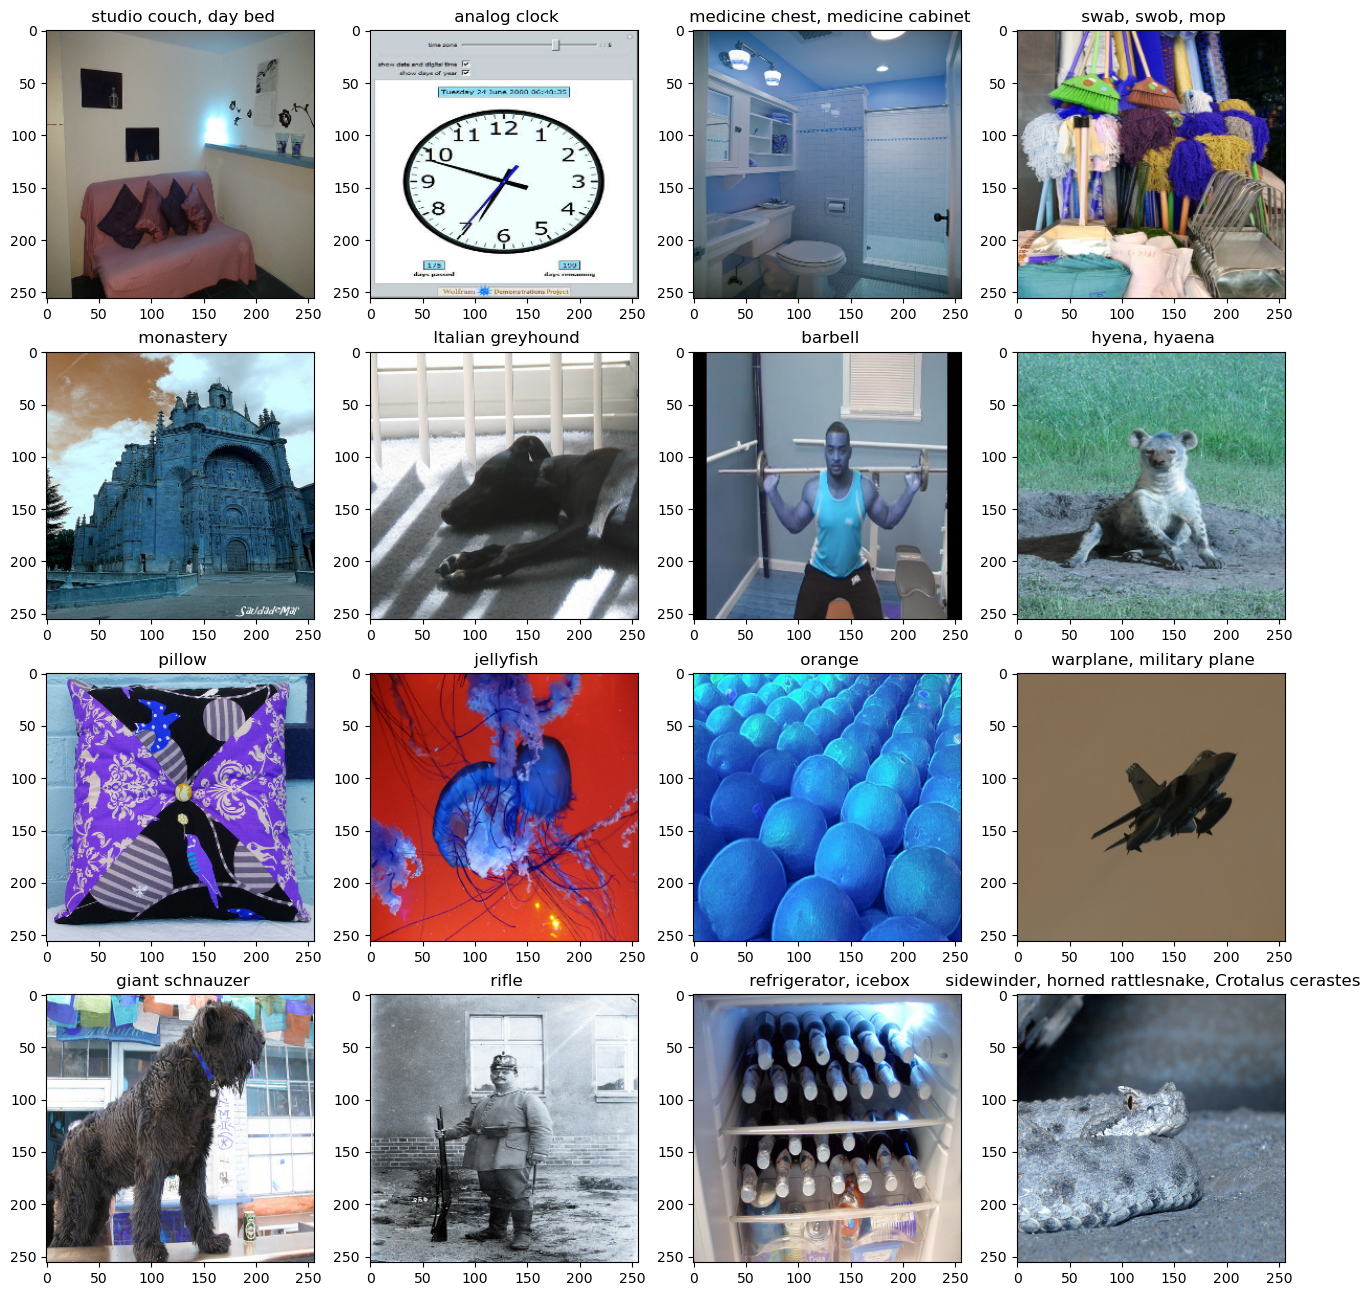

In [15]:
#Check data
f, ax = plt.subplots(4, 4, figsize=(16, 16))
indexes = [i for i in range(16)]
count = 0
for i in range(4):
    for j in range(4):
        index = indexes[count]
        ax[i, j].imshow(X_test[index][:, :, ::-1])
        ax[i, j].set_title(labels[y_test[index]][1])
        count += 1

## 2. Loading the models

In order to use a PyTorch model in `MapieClassifier`, we first need to convert it to the `scikit-learn` API. It can be done with a class like the following one.

In [17]:
class TorchToMapie():

    def __init__(self, torch_model, transform, batch_size):
        self.transform = transform
        self.trained_ = True
        self.batch_size = batch_size
        n_classes = [mod for mod in torch_model.modules()][-1].out_features
        self.classes_ = np.arange(n_classes)
        self.torch_model = torch_model


    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        preds = np.zeros((len(X), 1000))
        model = self.torch_model.eval()
        X_t = torch.zeros((len(X), 3, 224, 224)).type(torch.float32)
        for i, x in enumerate(X):
            x = x.astype('uint8')
            x_t = self.transform(x)
            X_t[i] = torch.unsqueeze(x_t, 0)
        BATCH_SIZE = min(len(X), self.batch_size)
        for batch in range(len(X)//BATCH_SIZE + 1):
            X_t_temp = X_t[batch*BATCH_SIZE:min((batch + 1)*BATCH_SIZE, len(X))]
            X_t_temp = X_t_temp
            pred = model(X_t_temp)
            pred = torch.nn.functional.softmax(pred, dim=1)
            pred = np.reshape(pred.detach().numpy(), (len(X_t_temp), 1000))
            preds[batch*BATCH_SIZE:min((batch + 1)*BATCH_SIZE, len(X))] = pred

        return preds


    def predict(self, X):
        pred_proba = self.predict_proba(X)
        pred = (pred_proba == pred_proba.max(axis=1)[:,None]).astype(int)

        return pred

    def __sklearn_is_fitted__(self):
        return True

In [18]:
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225])
])


In [19]:
my_models = {
    'resnet152': models.resnet152(pretrained=True),
    #'resnet101': models.resnet101(pretrained=True),
    #'resnet50': models.resnet50(pretrained=True),
    #'resnet18': models.resnet18(pretrained=True),
    #'densenet161': models.densenet161(pretrained=True),
    #'vgg16': models.vgg16(pretrained=True),
    #'inception': models.inception_v3(pretrained=True),
}

/Users/vblot/anaconda3/envs/loreal/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vblot/anaconda3/envs/loreal/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 3. Estimating the prediction sets

In [20]:
def count_null_set(y):
    count = 0
    for pred in y[:, :]:
        if np.sum(pred) == 0:
            count += 1
    return count


In [21]:
method_params = {
    #"naive": ("naive", True),
    "score": ("score", True),
    "cumulated_score": ("cumulated_score", True),
    "crf_score": ("crf_score", True),
    "crf_aps": ("crf_aps", True),
    #"random_cumulated_score": ("cumulated_score", "randomized"),
    #"raps": ("raps", True),
    #"random_raps": ("raps", "randomized"),
    #"top_k": ("top_k", False)
}
batch_size = 8

In [22]:
def get_residual(model, X_res, y_res, method):
    if method == "crf_score":
        y_pred_proba = model.predict_proba(X_res)
        y_res_predict_new = np.take_along_axis(
            1 - y_pred_proba, np.expand_dims(y_res, axis=1), axis=1
        )
    elif method == "crf_aps":
        y_pred_proba = model.predict_proba(X_res)
        cum_sum_proba = _get_true_label_cumsum_proba(y_res, y_pred_proba=y_pred_proba)
        y_res_predict_new = cum_sum_proba[0].ravel()
    return y_res_predict_new

In [28]:
my_models["resnet152"]



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
y_p = TorchToMapie(my_models["resnet152"], transform, batch_size).predict(X_calib)

In [26]:
accuracy_score(y_p.argmax(axis=1), y_calib)

0.7628156082631982

In [27]:
from sklearn.preprocessing import label_binarize
def _get_true_label_cumsum_proba(
    y,
    y_pred_proba,
):
    y_true = label_binarize(y=y, classes=np.unique(y))
    index_sorted = np.fliplr(np.argsort(y_pred_proba, axis=1))
    y_pred_proba_sorted = np.take_along_axis(y_pred_proba, index_sorted, axis=1)
    y_true_sorted = np.take_along_axis(y_true, index_sorted, axis=1)
    y_pred_proba_sorted_cumsum = np.cumsum(y_pred_proba_sorted, axis=1)
    cutoff = np.argmax(y_true_sorted, axis=1)
    true_label_cumsum_proba = np.take_along_axis(
        y_pred_proba_sorted_cumsum, cutoff.reshape(-1, 1), axis=1
    )

    return true_label_cumsum_proba, cutoff + 1

In [36]:
# y_preds_all_models, y_pss_all_models = {}, {}
# alphas = np.arange(0.1, 1, .1)
# for model_name, model in my_models.items():
#
#     mapie_model = TorchToMapie(model, transform, batch_size)
#     y_preds, y_pss = {}, {}
#
#     for method_name, (method, include_last_label) in method_params.items():
#         print(model_name, method_name)
#         mapie = MapieClassifier(mapie_model, method=method, cv="prefit", random_state=42)
#         mapie.fit(X_calib, y_calib)
#         y_preds[method_name], y_pss[method_name] = mapie.predict(X_test, alpha=alphas, include_last_label=include_last_label)
#     y_preds_all_models[model_name] = y_preds
#     y_pss_all_models[model_name] = y_pss

alphas = np.arange(0.1, 1, .1)
from sklearn.ensemble import RandomForestRegressor
for model_name, model in my_models.items():

    mapie_model = TorchToMapie(model, transform, batch_size)
    y_preds, y_pss = {}, {}
    for name, (method, include_last_label) in method_params.items():
        if 'crf' in name:
            y_res_score = get_residual(mapie_model, X_res, y_res, method=method)
            regr = RandomForestRegressor().fit(X_res, y_res_score)
            mapie = MapieClassifier(estimator=mapie_model, cv="prefit", method=method)
            y_cal_pred = regr.predict(X_calib)
            mapie.fit(X_calib, y_calib, residuals=y_cal_pred)
            y_test_pred_res = regr.predict(X_test)
            y_preds[name], y_pss[name] = mapie.predict(X_test, alpha=alphas, residuals=y_test_pred_res)
        else:
            mapie = MapieClassifier(estimator=mapie_model, method=method, cv="prefit", random_state=42)
            mapie.fit(X_calib, y_calib)
            y_preds[name], y_pss[name] = mapie.predict(X_test, alpha=alphas)


/content/MAPIE/mapie/classification.py:884: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 1000 unique labels while calibration have 767 unique labels
  warnings.warn(
/content/MAPIE/mapie/classification.py:884: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 1000 unique labels while calibration have 767 unique labels
  warnings.warn(


ValueError: ignored

In [32]:
name

NameError: ignored

In [ ]:
nulls, coverages, accuracies, sizes = {}, {}, {}, {}

for model_name in my_models.keys():
    nulls[model_name] = {}
    coverages[model_name] = {}
    accuracies[model_name] = {}
    sizes[model_name] = {}
    for method_name, (method, include_last_label) in method_params.items():
        accuracies[model_name][method_name] = accuracy_score(y_true_test, y_preds_all_models[model_name][method_name])
        nulls[model_name][method_name] = [
            count_null_set(y_pss_all_models[model_name][method_name][:, :, i])  for i, _ in enumerate(alphas)
        ]
        coverages[model_name][method_name] = [
            classification_coverage_score(
                y_test, y_pss_all_models[model_name][method_name][:, :, i]
            ) for i, _ in enumerate(alphas)
        ]
        sizes[model_name][method_name] = [
            y_pss_all_models[model_name][method_name][:, :, i].sum(axis=1).mean() for i, _ in enumerate(alphas)
        ]

In [ ]:
nulls_90 = {k : {k1 : v1[0] for k1, v1 in nulls[k].items()} for k, v in nulls.items()}
coverages_90 = {k : {k1 : v1[0] for k1, v1 in coverages[k].items()} for k, v in coverages.items()}
sizes_90 = {k : {k1 : v1[0] for k1, v1 in sizes[k].items()} for k, v in sizes.items()}


In [ ]:
summary_df = pd.concat(
    [
        pd.DataFrame(coverages_90).T,
        pd.DataFrame(nulls_90).T,
        pd.DataFrame(sizes_90).T
    ],
    axis=1,
    keys=["Coverages", "Number of null sets", "Average prediction set sizes"]
).round(3)

In [ ]:
summary_df#.to_csv("results_W_rraps.csv")

Coverages                               Number of null sets  \
          cumulated_score random_cumulated_score  score     cumulated_score   
resnet152           0.943                  0.906  0.901                   0   

                                       Average prediction set sizes  \
          random_cumulated_score score              cumulated_score   
resnet152                     41     0                        8.015   

                                         
          random_cumulated_score  score  
resnet152                  7.773  2.091

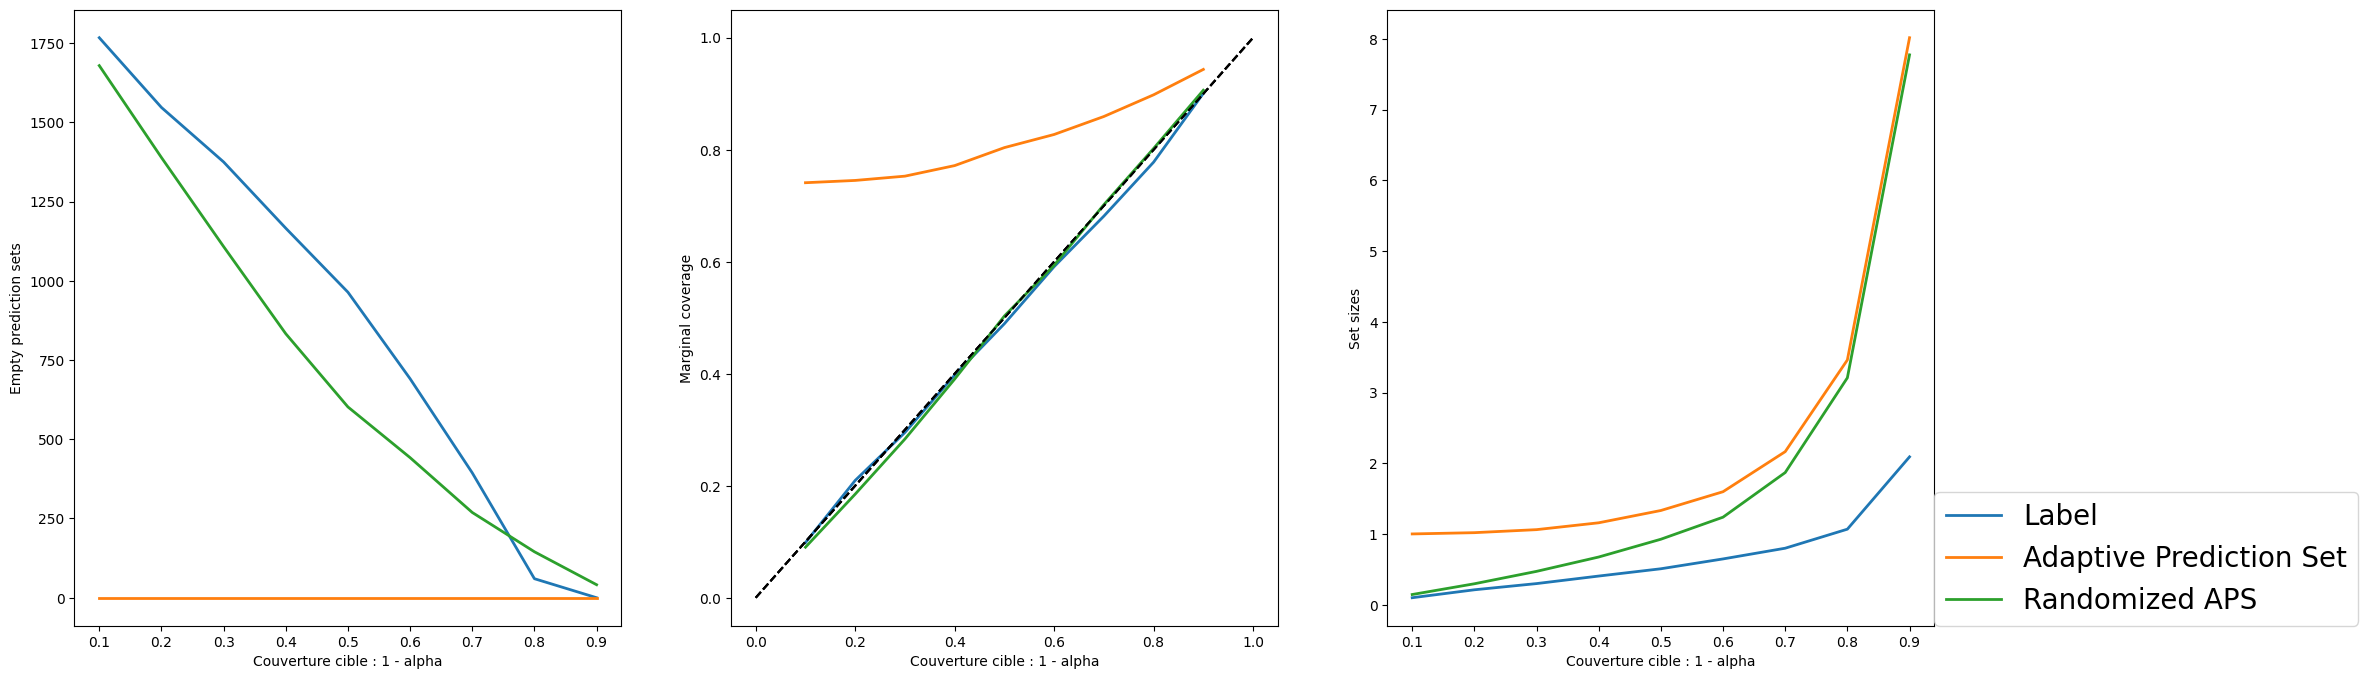

In [ ]:
vars_y = [nulls["resnet152"], coverages["resnet152"], sizes["resnet152"]]
label_mapping = {
    #"naive": "Naive",
    "score": "Label",
    "cumulated_score": "Adaptive Prediction Set",
    "random_cumulated_score": "Randomized APS",
    #"top_k": "Top-K",
    #"raps": "raps",
    #"random_raps": "Random RAPS"
}
labels_y = ["Empty prediction sets", "Marginal coverage", "Set sizes"]
fig, axs = plt.subplots(1, len(vars_y), figsize=(8*len(vars_y), 8))
for i, var in enumerate(vars_y):
    for name, (method, include_last_label) in method_params.items():
        axs[i].plot(1 - alphas, var[name], label=label_mapping[name], linewidth=2)
        if i == 1:
            axs[i].plot([0, 1], [0, 1], ls="--", color="k")
    axs[i].set_xlabel("Couverture cible : 1 - alpha")
    axs[i].set_ylabel(labels_y[i])
    if i == len(vars_y) - 1:
        axs[i].legend(fontsize=20, loc=[1, 0])

# Viz

In [ ]:
SPACE_BETWEEN_LABELS = 30
SPACE_IN_SUBPLOTS = 4.0
FONT_SIZE = 18

In [ ]:
def prepare_plot(y_methods: Dict[str, Tuple], n_images: int) -> np.ndarray:
    """
    Prepare the number and the disposition of the plots according to
    the number of images.

    Paramters:
    y_methods: Dict[str, Tuple]
        Methods we want to compare.

    n_images: int
        Number of images to plot.

    Returns
    -------
    np.ndarray
    """
    plt.rcParams.update({'font.size': FONT_SIZE})
    nrow = len(y_methods.keys())
    ncol = n_images
    s = 5
    f, ax = plt.subplots(nrow, ncol, figsize=(s*ncol, s*nrow))
    f.tight_layout(pad=SPACE_IN_SUBPLOTS)
    rows = [i for i in y_methods.keys()]

    for row in rows: #zip(ax[:,0], rows):
      ax[0].set_ylabel(row, rotation=90, size='large')

    return ax


In [ ]:
def get_position(y_set: List, label: str, count: int, count_true: int) -> float:
    """
    Return the position of each label according to the number of labels to plot.

    Paramters
    ---------
    y_set: List
        Set of predicted labels for one image.

    label: str
        Indice of the true label.

    count: int
        Index of the label.

    count_true: int
        Total number of labels in the prediction set.

    Returns
    -------
    float
    """
    if y_set[label] :
        position = - (count_true - count)*SPACE_BETWEEN_LABELS

    else:
        position = - (count_true + 2 - count)*SPACE_BETWEEN_LABELS

    return position


def add_text(
    ax: np.ndarray, indices: Tuple, position: float,
    label_name: str, proba: float, color: str, missing: bool = False
) -> None:
    """
    Add the text to the corresponding image.

    Parameters
    ----------
    ax: np.ndarray
        Matrix of the images to plot.

    indices: Tuple
        Tuple indicating the indices of the image to put
        the text on.

    position: float
        Position of the text on the image.

    label_name: str
        Name of the label to plot.

    proba: float
        Proba associated to this label.

    color: str
        Color of the text.

    missing: bool
        Whether or not the true label is missing in the
        prediction set.

        By default False.

    """
    if not missing :
        text = f"{label_name} : {proba:.4f}"
    else:
        text = f"True label : {label_name} ({proba:.4f})"
    i, j = indices
    ax[j].text(
        110,
        position,
        text,
        ha="center", va="top",
        color=color,
    )



In [ ]:
def plot_prediction_sets(
    X: np.ndarray, y: np.ndarray,
    y_pred_proba: np.ndarray,
    y_methods: Dict[str, np.ndarray],
    n_images: int, label_names: Dict,
    random_state: Union[int, None] = None
) -> None:
    """
    Plot random images with their associated prediction
    set for all the required methods.

    Parameters
    ----------
    X: np.ndarray of shape (n_sample, width, height, n_channels)
        Array containing images.

    y: np.ndarray of shape (n_samples, )
        Labels of the images.

    y_pred_proba: np.ndarray of shape (n_samples, n_labels)
        Softmax output of the model.

    y_methods: Dict[str, np.ndarray]
        Outputs of the MapieClassifier with the different
        choosen methods.

    n_images: int
        Number of images to plot

    random_state: Union[int, None]
        Random state to use to choose the images.

        By default None.
    """
    random.seed(random_state)
    indices = random.sample(range(len(X)), n_images)

    y_true = y[indices]
    y_pred_proba = y_pred_proba[indices]
    ax = prepare_plot(y_methods, n_images)

    for i, method in enumerate(y_methods):
        y_sets = y_methods[method][indices]

        for j in range(n_images):
            # print(i, j)
            y_set = y_sets[j]
            img, label= X[indices[j]], y_true[j]

            ax[j].imshow(img)

            count_true = np.sum(y_set)
            index_sorted_proba = np.argsort(-y_pred_proba[j])

            for count in range(count_true):
                index_pred = index_sorted_proba[count]
                proba = y_pred_proba[j][index_pred]
                label_name = label_names[index_pred][-1].split(',')[-1]
                color = 'green' if index_pred == y_true[j] else 'red'
                position = get_position(y_set, label, count, count_true)

                add_text(ax, (i, j), position, label_name, proba, color)

            if not y_set[label] :
                label_name = label_names[label][-1].split(',')[-1]
                proba = y_pred_proba[j][label]
                add_text(ax, (i, j), -20, label_name, proba, color= 'orange', missing=True)


In [ ]:
y_ps_90 = {method: y_ps[:, :, 1] for method, y_ps in y_pss.items() if method == "cumulated_score"}
y_pred_proba = mapie_model.predict_proba(X_test)


In [ ]:
y_ps_90.keys()

dict_keys(['cumulated_score'])

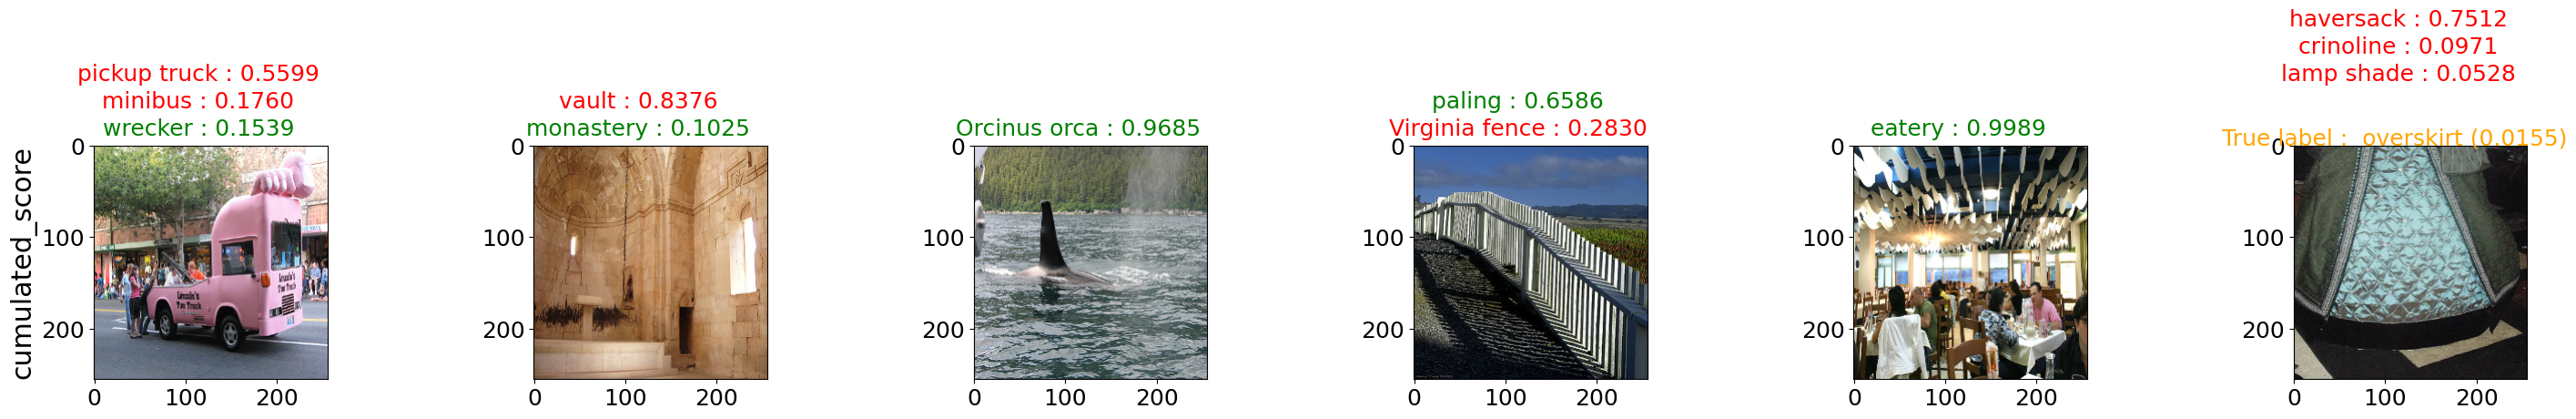

In [ ]:
#23
#30
plot_prediction_sets(X_test, np.array(y_test), y_pred_proba, y_ps_90, 6, labels, random_state=35)

## Old cells

In [ ]:
# all_in_one = pd.DataFrame(
#     recap_all_in_one,
#     columns=['model_name',
#                              'accuracy',
#                              'average size of naive prediction set',
#                              'naive coverage',
#                              'number of null sets for naive method',
#                              'average size of prediction set with score method ',
#                              'score method coverage',
#                              'number of null sets for score method',
#                              'average size of prediction set with culumated score method',
#                              'number of null sets for cumulated score method',
#                              'cumulated score coverage',
#                              'average size of prediction set with randomized culumated score method',
#                              'number of null sets for randomized cumulated score method',
#                              'randomized cumulated score coverage',
#                              'average size of top-k prediciton set',
#                              'top-k coverage',
#                              'number of null sets for top-k method',
#                              ])

# all_in_one

In [ ]:

# nulls[name], coverages[name], accuracies[name],
#         nulls_[method] = count_null_set(y_ps)
#         coverages_[method] = classification_coverage_score(y_test, y_ps[:, :, 0])
#         accuracies_[method] = accuracy_score(y_true, y_pred)
# print(name, coverages[name])
#     recap_all_in_one.append([model[0],
#                              accuracy_score(y_true, y_pred),
#                              np.sum(y_naive)/len(X_test),
#                              naive_coverage,
#                              null_naive,
#                              np.sum(y_score)/len(X_test),
#                              score_coverage,
#                              null_score,
#                              np.sum(y_aps)/len(X_test),
#                              null_aps,
#                              aps_coverage,
#                              np.sum(y_aps_random)/len(X_test),
#                              null_aps_random,
#                              aps_coverage_random,

#                              np.sum(y_topk)/len(X_test),
#                              null_topk,
#                              topk_coverage])


In [ ]:
# from sklearn import preprocessing
# y_true = preprocessing.LabelBinarizer(sparse_output=True).fit(y).transform(y)
# y_true2 = preprocessing.LabelBinarizer(sparse_output=False).fit(y).transform(y)
# y_true3 = preprocessing.label_binarize(y=y, classes=np.arange(max(y)+1))

In [ ]:
# mapie_model = TorchToMapie(model, transform, BATCH_SIZE)
# mapie = MapieClassifier(
#     estimator=mapie_model, method="cumulated_score", cv="prefit", random_state=42
# )
# mapie.fit(X, y, image_input=True)
# y_pred, y_ps = mapie.predict(X_test, alpha=0.1, include_last_label="randomized")

In [ ]:
# from typing_extensions import TypedDict
# Params = TypedDict("Params", {"method": str, "cv": int})
# STRATEGIES = {
#     "jackknife_plus": Params(method="plus", cv=-1),
#     "jackknife_minmax": Params(method="minmax", cv=-1),
#     "cv_plus": Params(method="plus", cv=10),
#     "cv_minmax": Params(method="minmax", cv=10),
# }